In [4]:
#Imports
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#Data
class SRPatchDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, patch_size=32, scale=4, patches_per_image=10):
        self.lr_paths = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir) if f.endswith(('.png', '.jpg'))])
        self.hr_paths = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir) if f.endswith(('.png', '.jpg'))])
        self.patch_size = patch_size
        self.scale = scale
        self.patches_per_image = patches_per_image
        self.lr_patches, self.hr_patches = self.extract_patches()

    def extract_patches(self):
        lr_patches, hr_patches = [], []
        for lr_path, hr_path in zip(self.lr_paths, self.hr_paths):
            lr = cv2.imread(lr_path, cv2.IMREAD_COLOR).astype(np.float32) / 255.0
            hr = cv2.imread(hr_path, cv2.IMREAD_COLOR).astype(np.float32) / 255.0
            h, w = lr.shape[:2]
            for _ in range(self.patches_per_image):
                x = random.randint(0, h - self.patch_size)
                y = random.randint(0, w - self.patch_size)
                lr_patch = lr[x:x+self.patch_size, y:y+self.patch_size]
                hr_patch = hr[x*self.scale:(x+self.patch_size)*self.scale, y*self.scale:(y+self.patch_size)*self.scale]
                if hr_patch.shape[0] != self.patch_size * self.scale or hr_patch.shape[1] != self.patch_size * self.scale:
                    continue
                lr_up = cv2.resize(lr_patch, (hr_patch.shape[1], hr_patch.shape[0]), interpolation=cv2.INTER_CUBIC)
                lr_patches.append(np.transpose(lr_up, (2, 0, 1)))
                hr_patches.append(np.transpose(hr_patch, (2, 0, 1)))
        return lr_patches, hr_patches

    def __len__(self):
        return len(self.lr_patches)

    def __getitem__(self, idx):
        lr = torch.tensor(self.lr_patches[idx], dtype=torch.float32)
        hr = torch.tensor(self.hr_patches[idx], dtype=torch.float32)
        return lr, hr

#Model
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return torch.clamp(x, 0.0, 1.0)

#Train
def train(model, dataloader, device, epochs=10, lr=1e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for lr_imgs, hr_imgs in loop:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            preds = model(lr_imgs)
            loss = loss_fn(preds, hr_imgs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(dataloader):.6f}")

#Eval
def evaluate(model, lr_dir, hr_dir, device):
    model.eval()
    model.to(device)
    psnr_scores = []
    ssim_scores = []

    lr_files = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir) if f.endswith(('.png', '.jpg'))])
    hr_files = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir) if f.endswith(('.png', '.jpg'))])

    with torch.no_grad():
        for lr_path, hr_path in zip(lr_files, hr_files):
            lr_img = cv2.imread(lr_path, cv2.IMREAD_COLOR).astype(np.float32) / 255.0
            hr_img = cv2.imread(hr_path, cv2.IMREAD_COLOR).astype(np.float32) / 255.0
            h, w = hr_img.shape[:2]
            lr_up = cv2.resize(lr_img, (w, h), interpolation=cv2.INTER_CUBIC)
            input_tensor = torch.tensor(lr_up.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device)
            output = model(input_tensor).cpu().squeeze().numpy().transpose(1, 2, 0)
            output = np.clip(output, 0, 1)

            psnr_scores.append(psnr(hr_img, output, data_range=1.0))
            ssim_scores.append(ssim(hr_img, output, data_range=1.0, channel_axis=2))


    print(f"\nAverage PSNR: {np.mean(psnr_scores):.2f}")
    print(f"Average SSIM: {np.mean(ssim_scores):.4f}")

#Visualize
def visualize(model, lr_path, hr_path, device):
    model.eval()
    lr_img = cv2.imread(lr_path, cv2.IMREAD_COLOR).astype(np.float32) / 255.0
    hr_img = cv2.imread(hr_path, cv2.IMREAD_COLOR).astype(np.float32) / 255.0
    h, w = hr_img.shape[:2]
    lr_up = cv2.resize(lr_img, (w, h), interpolation=cv2.INTER_CUBIC)

    input_tensor = torch.tensor(lr_up.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor).cpu().squeeze().numpy().transpose(1, 2, 0)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(lr_up[..., ::-1])
    axs[0].set_title("Bicubic Upsample")
    axs[1].imshow(output[..., ::-1])
    axs[1].set_title("SRCNN Output")
    axs[2].imshow(hr_img[..., ::-1])
    axs[2].set_title("Ground Truth HR")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


train_lr = '/ssd_scratch/harish.j/SISR/data/image_super_resolution_dataset/scaling_4x/train/LR'
train_hr = '/ssd_scratch/harish.j/SISR/data/image_super_resolution_dataset/scaling_4x/train/HR'
test_lr = '/ssd_scratch/harish.j/SISR/data/image_super_resolution_dataset/scaling_4x/test/LR'
test_hr = '/ssd_scratch/harish.j/SISR/data/image_super_resolution_dataset/scaling_4x/test/HR'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = SRPatchDataset(train_lr, train_hr, patch_size=32, scale=4, patches_per_image=10)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

model = SRCNN()
train(model, train_loader, device, epochs=300)
evaluate(model, test_lr, test_hr, device)


Epoch 1/300: 100%|█████████████████| 100/100 [00:00<00:00, 162.44it/s, loss=0.0151]


Epoch 1: Avg Loss = 0.048977


Epoch 2/300: 100%|████████████████| 100/100 [00:00<00:00, 176.74it/s, loss=0.00914]


Epoch 2: Avg Loss = 0.010742


Epoch 3/300: 100%|████████████████| 100/100 [00:00<00:00, 175.94it/s, loss=0.00543]


Epoch 3: Avg Loss = 0.007776


Epoch 4/300: 100%|█████████████████| 100/100 [00:00<00:00, 176.91it/s, loss=0.0063]


Epoch 4: Avg Loss = 0.007088


Epoch 5/300: 100%|████████████████| 100/100 [00:00<00:00, 175.67it/s, loss=0.00395]


Epoch 5: Avg Loss = 0.006645


Epoch 6/300: 100%|████████████████| 100/100 [00:00<00:00, 179.81it/s, loss=0.00494]


Epoch 6: Avg Loss = 0.006327


Epoch 7/300: 100%|█████████████████| 100/100 [00:00<00:00, 182.14it/s, loss=0.0114]


Epoch 7: Avg Loss = 0.006096


Epoch 8/300: 100%|████████████████| 100/100 [00:00<00:00, 179.54it/s, loss=0.00576]


Epoch 8: Avg Loss = 0.005966


Epoch 9/300: 100%|████████████████| 100/100 [00:00<00:00, 182.51it/s, loss=0.00589]


Epoch 9: Avg Loss = 0.005880


Epoch 10/300: 100%|████████████████| 100/100 [00:00<00:00, 182.39it/s, loss=0.0107]


Epoch 10: Avg Loss = 0.005795


Epoch 11/300: 100%|███████████████| 100/100 [00:00<00:00, 180.18it/s, loss=0.00623]


Epoch 11: Avg Loss = 0.005750


Epoch 12/300: 100%|██████████████████| 100/100 [00:00<00:00, 167.37it/s, loss=0.01]


Epoch 12: Avg Loss = 0.005711


Epoch 13/300: 100%|███████████████| 100/100 [00:00<00:00, 163.54it/s, loss=0.00559]


Epoch 13: Avg Loss = 0.005686


Epoch 14/300: 100%|███████████████| 100/100 [00:00<00:00, 162.71it/s, loss=0.00503]


Epoch 14: Avg Loss = 0.005643


Epoch 15/300: 100%|███████████████| 100/100 [00:00<00:00, 162.59it/s, loss=0.00867]


Epoch 15: Avg Loss = 0.005622


Epoch 16/300: 100%|███████████████| 100/100 [00:00<00:00, 166.22it/s, loss=0.00368]


Epoch 16: Avg Loss = 0.005599


Epoch 17/300: 100%|███████████████| 100/100 [00:00<00:00, 180.76it/s, loss=0.00611]


Epoch 17: Avg Loss = 0.005579


Epoch 18/300: 100%|███████████████| 100/100 [00:00<00:00, 178.82it/s, loss=0.00631]


Epoch 18: Avg Loss = 0.005559


Epoch 19/300: 100%|███████████████| 100/100 [00:00<00:00, 175.78it/s, loss=0.00508]


Epoch 19: Avg Loss = 0.005547


Epoch 20/300: 100%|███████████████| 100/100 [00:00<00:00, 173.57it/s, loss=0.00775]


Epoch 20: Avg Loss = 0.005526


Epoch 21/300: 100%|███████████████| 100/100 [00:00<00:00, 163.96it/s, loss=0.00756]


Epoch 21: Avg Loss = 0.005568


Epoch 22/300: 100%|███████████████| 100/100 [00:00<00:00, 159.00it/s, loss=0.00688]


Epoch 22: Avg Loss = 0.005501


Epoch 23/300: 100%|███████████████| 100/100 [00:00<00:00, 158.71it/s, loss=0.00689]


Epoch 23: Avg Loss = 0.005487


Epoch 24/300: 100%|███████████████| 100/100 [00:00<00:00, 155.37it/s, loss=0.00547]


Epoch 24: Avg Loss = 0.005472


Epoch 25/300: 100%|███████████████| 100/100 [00:00<00:00, 154.58it/s, loss=0.00397]


Epoch 25: Avg Loss = 0.005464


Epoch 26/300: 100%|████████████████| 100/100 [00:00<00:00, 156.58it/s, loss=0.0059]


Epoch 26: Avg Loss = 0.005484


Epoch 27/300: 100%|███████████████| 100/100 [00:00<00:00, 154.60it/s, loss=0.00721]


Epoch 27: Avg Loss = 0.005450


Epoch 28/300: 100%|████████████████| 100/100 [00:00<00:00, 154.53it/s, loss=0.0049]


Epoch 28: Avg Loss = 0.005437


Epoch 29/300: 100%|███████████████| 100/100 [00:00<00:00, 153.73it/s, loss=0.00766]


Epoch 29: Avg Loss = 0.005427


Epoch 30/300: 100%|███████████████| 100/100 [00:00<00:00, 156.45it/s, loss=0.00327]


Epoch 30: Avg Loss = 0.005419


Epoch 31/300: 100%|███████████████| 100/100 [00:00<00:00, 159.90it/s, loss=0.00737]


Epoch 31: Avg Loss = 0.005427


Epoch 32/300: 100%|████████████████| 100/100 [00:00<00:00, 154.69it/s, loss=0.0061]


Epoch 32: Avg Loss = 0.005407


Epoch 33/300: 100%|███████████████| 100/100 [00:00<00:00, 157.60it/s, loss=0.00706]


Epoch 33: Avg Loss = 0.005398


Epoch 34/300: 100%|████████████████| 100/100 [00:00<00:00, 158.64it/s, loss=0.0035]


Epoch 34: Avg Loss = 0.005398


Epoch 35/300: 100%|███████████████| 100/100 [00:00<00:00, 158.05it/s, loss=0.00507]


Epoch 35: Avg Loss = 0.005392


Epoch 36/300: 100%|███████████████| 100/100 [00:00<00:00, 156.76it/s, loss=0.00751]


Epoch 36: Avg Loss = 0.005376


Epoch 37/300: 100%|███████████████| 100/100 [00:00<00:00, 158.35it/s, loss=0.00524]


Epoch 37: Avg Loss = 0.005373


Epoch 38/300: 100%|███████████████| 100/100 [00:00<00:00, 157.25it/s, loss=0.00381]


Epoch 38: Avg Loss = 0.005363


Epoch 39/300: 100%|███████████████| 100/100 [00:00<00:00, 156.40it/s, loss=0.00442]


Epoch 39: Avg Loss = 0.005371


Epoch 40/300: 100%|███████████████| 100/100 [00:00<00:00, 156.02it/s, loss=0.00357]


Epoch 40: Avg Loss = 0.005354


Epoch 41/300: 100%|███████████████| 100/100 [00:00<00:00, 156.48it/s, loss=0.00481]


Epoch 41: Avg Loss = 0.005348


Epoch 42/300: 100%|███████████████| 100/100 [00:00<00:00, 154.80it/s, loss=0.00576]


Epoch 42: Avg Loss = 0.005337


Epoch 43/300: 100%|███████████████| 100/100 [00:00<00:00, 157.72it/s, loss=0.00344]


Epoch 43: Avg Loss = 0.005445


Epoch 44/300: 100%|███████████████| 100/100 [00:00<00:00, 154.70it/s, loss=0.00361]


Epoch 44: Avg Loss = 0.005325


Epoch 45/300: 100%|███████████████| 100/100 [00:00<00:00, 154.41it/s, loss=0.00815]


Epoch 45: Avg Loss = 0.005326


Epoch 46/300: 100%|███████████████| 100/100 [00:00<00:00, 155.70it/s, loss=0.00538]


Epoch 46: Avg Loss = 0.005323


Epoch 47/300: 100%|███████████████| 100/100 [00:00<00:00, 152.70it/s, loss=0.00507]


Epoch 47: Avg Loss = 0.005347


Epoch 48/300: 100%|████████████████| 100/100 [00:00<00:00, 153.33it/s, loss=0.0056]


Epoch 48: Avg Loss = 0.005311


Epoch 49/300: 100%|███████████████| 100/100 [00:00<00:00, 152.56it/s, loss=0.00462]


Epoch 49: Avg Loss = 0.005307


Epoch 50/300: 100%|███████████████| 100/100 [00:00<00:00, 151.86it/s, loss=0.00353]


Epoch 50: Avg Loss = 0.005304


Epoch 51/300: 100%|████████████████| 100/100 [00:00<00:00, 151.52it/s, loss=0.0065]


Epoch 51: Avg Loss = 0.005295


Epoch 52/300: 100%|███████████████| 100/100 [00:00<00:00, 151.45it/s, loss=0.00673]


Epoch 52: Avg Loss = 0.005293


Epoch 53/300: 100%|███████████████| 100/100 [00:00<00:00, 153.78it/s, loss=0.00612]


Epoch 53: Avg Loss = 0.005289


Epoch 54/300: 100%|███████████████| 100/100 [00:00<00:00, 152.12it/s, loss=0.00578]


Epoch 54: Avg Loss = 0.005294


Epoch 55/300: 100%|███████████████| 100/100 [00:00<00:00, 149.47it/s, loss=0.00696]


Epoch 55: Avg Loss = 0.005283


Epoch 56/300: 100%|███████████████| 100/100 [00:00<00:00, 152.39it/s, loss=0.00289]


Epoch 56: Avg Loss = 0.005296


Epoch 57/300: 100%|███████████████| 100/100 [00:00<00:00, 149.82it/s, loss=0.00548]


Epoch 57: Avg Loss = 0.005279


Epoch 58/300: 100%|███████████████| 100/100 [00:00<00:00, 147.72it/s, loss=0.00321]


Epoch 58: Avg Loss = 0.005282


Epoch 59/300: 100%|███████████████| 100/100 [00:00<00:00, 150.34it/s, loss=0.00416]


Epoch 59: Avg Loss = 0.005261


Epoch 60/300: 100%|███████████████| 100/100 [00:00<00:00, 146.74it/s, loss=0.00519]


Epoch 60: Avg Loss = 0.005259


Epoch 61/300: 100%|███████████████| 100/100 [00:00<00:00, 145.70it/s, loss=0.00351]


Epoch 61: Avg Loss = 0.005291


Epoch 62/300: 100%|███████████████| 100/100 [00:00<00:00, 145.97it/s, loss=0.00575]


Epoch 62: Avg Loss = 0.005255


Epoch 63/300: 100%|███████████████| 100/100 [00:00<00:00, 148.01it/s, loss=0.00412]


Epoch 63: Avg Loss = 0.005250


Epoch 64/300: 100%|███████████████| 100/100 [00:00<00:00, 151.67it/s, loss=0.00735]


Epoch 64: Avg Loss = 0.005252


Epoch 65/300: 100%|███████████████| 100/100 [00:00<00:00, 153.38it/s, loss=0.00752]


Epoch 65: Avg Loss = 0.005249


Epoch 66/300: 100%|███████████████| 100/100 [00:00<00:00, 164.89it/s, loss=0.00709]


Epoch 66: Avg Loss = 0.005354


Epoch 67/300: 100%|███████████████| 100/100 [00:00<00:00, 166.37it/s, loss=0.00711]


Epoch 67: Avg Loss = 0.005234


Epoch 68/300: 100%|███████████████| 100/100 [00:00<00:00, 167.55it/s, loss=0.00642]


Epoch 68: Avg Loss = 0.005227


Epoch 69/300: 100%|███████████████| 100/100 [00:00<00:00, 165.94it/s, loss=0.00433]


Epoch 69: Avg Loss = 0.005227


Epoch 70/300: 100%|███████████████| 100/100 [00:00<00:00, 168.98it/s, loss=0.00566]


Epoch 70: Avg Loss = 0.005219


Epoch 71/300: 100%|████████████████| 100/100 [00:00<00:00, 175.79it/s, loss=0.0023]


Epoch 71: Avg Loss = 0.005218


Epoch 72/300: 100%|███████████████| 100/100 [00:00<00:00, 175.18it/s, loss=0.00568]


Epoch 72: Avg Loss = 0.005218


Epoch 73/300: 100%|████████████████| 100/100 [00:00<00:00, 174.21it/s, loss=0.0041]


Epoch 73: Avg Loss = 0.005226


Epoch 74/300: 100%|███████████████| 100/100 [00:00<00:00, 153.18it/s, loss=0.00218]


Epoch 74: Avg Loss = 0.005238


Epoch 75/300: 100%|███████████████| 100/100 [00:00<00:00, 161.23it/s, loss=0.00387]


Epoch 75: Avg Loss = 0.005210


Epoch 76/300: 100%|███████████████| 100/100 [00:00<00:00, 167.28it/s, loss=0.00541]


Epoch 76: Avg Loss = 0.005206


Epoch 77/300: 100%|███████████████| 100/100 [00:00<00:00, 167.70it/s, loss=0.00593]


Epoch 77: Avg Loss = 0.005210


Epoch 78/300: 100%|███████████████| 100/100 [00:00<00:00, 169.40it/s, loss=0.00434]


Epoch 78: Avg Loss = 0.005201


Epoch 79/300: 100%|███████████████| 100/100 [00:00<00:00, 160.52it/s, loss=0.00433]


Epoch 79: Avg Loss = 0.005200


Epoch 80/300: 100%|███████████████| 100/100 [00:00<00:00, 144.65it/s, loss=0.00653]


Epoch 80: Avg Loss = 0.005196


Epoch 81/300: 100%|███████████████| 100/100 [00:00<00:00, 148.68it/s, loss=0.00719]


Epoch 81: Avg Loss = 0.005201


Epoch 82/300: 100%|███████████████| 100/100 [00:00<00:00, 149.83it/s, loss=0.00549]


Epoch 82: Avg Loss = 0.005199


Epoch 83/300: 100%|███████████████| 100/100 [00:00<00:00, 155.79it/s, loss=0.00361]


Epoch 83: Avg Loss = 0.005184


Epoch 84/300: 100%|███████████████| 100/100 [00:00<00:00, 153.86it/s, loss=0.00454]


Epoch 84: Avg Loss = 0.005184


Epoch 85/300: 100%|███████████████| 100/100 [00:00<00:00, 153.48it/s, loss=0.00681]


Epoch 85: Avg Loss = 0.005202


Epoch 86/300: 100%|███████████████| 100/100 [00:00<00:00, 145.75it/s, loss=0.00393]


Epoch 86: Avg Loss = 0.005180


Epoch 87/300: 100%|███████████████| 100/100 [00:00<00:00, 148.06it/s, loss=0.00731]


Epoch 87: Avg Loss = 0.005175


Epoch 88/300: 100%|███████████████| 100/100 [00:00<00:00, 146.27it/s, loss=0.00451]


Epoch 88: Avg Loss = 0.005174


Epoch 89/300: 100%|███████████████| 100/100 [00:00<00:00, 148.33it/s, loss=0.00398]


Epoch 89: Avg Loss = 0.005168


Epoch 90/300: 100%|███████████████| 100/100 [00:00<00:00, 141.27it/s, loss=0.00563]


Epoch 90: Avg Loss = 0.005167


Epoch 91/300: 100%|████████████████| 100/100 [00:00<00:00, 168.16it/s, loss=0.0062]


Epoch 91: Avg Loss = 0.005180


Epoch 92/300: 100%|███████████████| 100/100 [00:00<00:00, 167.18it/s, loss=0.00806]


Epoch 92: Avg Loss = 0.005165


Epoch 93/300: 100%|███████████████| 100/100 [00:00<00:00, 168.03it/s, loss=0.00792]


Epoch 93: Avg Loss = 0.005164


Epoch 94/300: 100%|███████████████| 100/100 [00:00<00:00, 165.95it/s, loss=0.00449]


Epoch 94: Avg Loss = 0.005164


Epoch 95/300: 100%|███████████████| 100/100 [00:00<00:00, 150.29it/s, loss=0.00446]


Epoch 95: Avg Loss = 0.005160


Epoch 96/300: 100%|███████████████| 100/100 [00:00<00:00, 151.29it/s, loss=0.00551]


Epoch 96: Avg Loss = 0.005166


Epoch 97/300: 100%|███████████████| 100/100 [00:00<00:00, 147.48it/s, loss=0.00236]


Epoch 97: Avg Loss = 0.005155


Epoch 98/300: 100%|███████████████| 100/100 [00:00<00:00, 151.81it/s, loss=0.00359]


Epoch 98: Avg Loss = 0.005151


Epoch 99/300: 100%|███████████████| 100/100 [00:00<00:00, 151.51it/s, loss=0.00813]


Epoch 99: Avg Loss = 0.005167


Epoch 100/300: 100%|██████████████| 100/100 [00:00<00:00, 153.87it/s, loss=0.00345]


Epoch 100: Avg Loss = 0.005147


Epoch 101/300: 100%|██████████████| 100/100 [00:00<00:00, 152.98it/s, loss=0.00608]


Epoch 101: Avg Loss = 0.005154


Epoch 102/300: 100%|██████████████| 100/100 [00:00<00:00, 151.12it/s, loss=0.00236]


Epoch 102: Avg Loss = 0.005159


Epoch 103/300: 100%|██████████████| 100/100 [00:00<00:00, 150.66it/s, loss=0.00594]


Epoch 103: Avg Loss = 0.005142


Epoch 104/300: 100%|██████████████| 100/100 [00:00<00:00, 151.33it/s, loss=0.00262]


Epoch 104: Avg Loss = 0.005150


Epoch 105/300: 100%|████████████████| 100/100 [00:00<00:00, 155.16it/s, loss=0.007]


Epoch 105: Avg Loss = 0.005143


Epoch 106/300: 100%|██████████████| 100/100 [00:00<00:00, 165.23it/s, loss=0.00374]


Epoch 106: Avg Loss = 0.005141


Epoch 107/300: 100%|██████████████| 100/100 [00:00<00:00, 169.66it/s, loss=0.00533]


Epoch 107: Avg Loss = 0.005145


Epoch 108/300: 100%|██████████████| 100/100 [00:00<00:00, 171.54it/s, loss=0.00725]


Epoch 108: Avg Loss = 0.005151


Epoch 109/300: 100%|███████████████| 100/100 [00:00<00:00, 151.48it/s, loss=0.0052]


Epoch 109: Avg Loss = 0.005145


Epoch 110/300: 100%|██████████████| 100/100 [00:00<00:00, 146.03it/s, loss=0.00878]


Epoch 110: Avg Loss = 0.005135


Epoch 111/300: 100%|██████████████| 100/100 [00:00<00:00, 146.65it/s, loss=0.00433]


Epoch 111: Avg Loss = 0.005139


Epoch 112/300: 100%|███████████████| 100/100 [00:00<00:00, 150.77it/s, loss=0.0079]


Epoch 112: Avg Loss = 0.005140


Epoch 113/300: 100%|██████████████| 100/100 [00:00<00:00, 150.72it/s, loss=0.00575]


Epoch 113: Avg Loss = 0.005129


Epoch 114/300: 100%|██████████████| 100/100 [00:00<00:00, 151.40it/s, loss=0.00436]


Epoch 114: Avg Loss = 0.005162


Epoch 115/300: 100%|██████████████| 100/100 [00:00<00:00, 154.13it/s, loss=0.00478]


Epoch 115: Avg Loss = 0.005125


Epoch 116/300: 100%|██████████████| 100/100 [00:00<00:00, 155.28it/s, loss=0.00329]


Epoch 116: Avg Loss = 0.005131


Epoch 117/300: 100%|███████████████| 100/100 [00:00<00:00, 150.37it/s, loss=0.0069]


Epoch 117: Avg Loss = 0.005124


Epoch 118/300: 100%|██████████████| 100/100 [00:00<00:00, 147.07it/s, loss=0.00411]


Epoch 118: Avg Loss = 0.005123


Epoch 119/300: 100%|██████████████| 100/100 [00:00<00:00, 157.11it/s, loss=0.00542]


Epoch 119: Avg Loss = 0.005121


Epoch 120/300: 100%|██████████████| 100/100 [00:00<00:00, 171.20it/s, loss=0.00516]


Epoch 120: Avg Loss = 0.005124


Epoch 121/300: 100%|██████████████| 100/100 [00:00<00:00, 171.60it/s, loss=0.00965]


Epoch 121: Avg Loss = 0.005128


Epoch 122/300: 100%|██████████████| 100/100 [00:00<00:00, 168.32it/s, loss=0.00394]


Epoch 122: Avg Loss = 0.005115


Epoch 123/300: 100%|███████████████| 100/100 [00:00<00:00, 167.04it/s, loss=0.0029]


Epoch 123: Avg Loss = 0.005123


Epoch 124/300: 100%|██████████████| 100/100 [00:00<00:00, 168.24it/s, loss=0.00435]


Epoch 124: Avg Loss = 0.005116


Epoch 125/300: 100%|██████████████| 100/100 [00:00<00:00, 165.73it/s, loss=0.00707]


Epoch 125: Avg Loss = 0.005121


Epoch 126/300: 100%|██████████████| 100/100 [00:00<00:00, 165.96it/s, loss=0.00408]


Epoch 126: Avg Loss = 0.005121


Epoch 127/300: 100%|██████████████| 100/100 [00:00<00:00, 150.16it/s, loss=0.00802]


Epoch 127: Avg Loss = 0.005112


Epoch 128/300: 100%|██████████████| 100/100 [00:00<00:00, 150.71it/s, loss=0.00742]


Epoch 128: Avg Loss = 0.005109


Epoch 129/300: 100%|██████████████| 100/100 [00:00<00:00, 153.51it/s, loss=0.00194]


Epoch 129: Avg Loss = 0.005108


Epoch 130/300: 100%|██████████████| 100/100 [00:00<00:00, 151.17it/s, loss=0.00442]


Epoch 130: Avg Loss = 0.005109


Epoch 131/300: 100%|██████████████| 100/100 [00:00<00:00, 151.09it/s, loss=0.00414]


Epoch 131: Avg Loss = 0.005110


Epoch 132/300: 100%|██████████████| 100/100 [00:00<00:00, 149.41it/s, loss=0.00561]


Epoch 132: Avg Loss = 0.005119


Epoch 133/300: 100%|██████████████| 100/100 [00:00<00:00, 150.23it/s, loss=0.00412]


Epoch 133: Avg Loss = 0.005110


Epoch 134/300: 100%|██████████████| 100/100 [00:00<00:00, 146.67it/s, loss=0.00372]


Epoch 134: Avg Loss = 0.005106


Epoch 135/300: 100%|██████████████| 100/100 [00:00<00:00, 146.93it/s, loss=0.00352]


Epoch 135: Avg Loss = 0.005113


Epoch 136/300: 100%|██████████████| 100/100 [00:00<00:00, 147.70it/s, loss=0.00723]


Epoch 136: Avg Loss = 0.005113


Epoch 137/300: 100%|██████████████| 100/100 [00:00<00:00, 149.26it/s, loss=0.00601]


Epoch 137: Avg Loss = 0.005103


Epoch 138/300: 100%|██████████████| 100/100 [00:00<00:00, 148.28it/s, loss=0.00549]


Epoch 138: Avg Loss = 0.005107


Epoch 139/300: 100%|███████████████| 100/100 [00:00<00:00, 149.11it/s, loss=0.0028]


Epoch 139: Avg Loss = 0.005099


Epoch 140/300: 100%|██████████████| 100/100 [00:00<00:00, 152.68it/s, loss=0.00772]


Epoch 140: Avg Loss = 0.005097


Epoch 141/300: 100%|██████████████| 100/100 [00:00<00:00, 149.61it/s, loss=0.00334]


Epoch 141: Avg Loss = 0.005094


Epoch 142/300: 100%|███████████████| 100/100 [00:00<00:00, 142.61it/s, loss=0.0049]


Epoch 142: Avg Loss = 0.005117


Epoch 143/300: 100%|██████████████| 100/100 [00:00<00:00, 149.70it/s, loss=0.00436]


Epoch 143: Avg Loss = 0.005093


Epoch 144/300: 100%|██████████████| 100/100 [00:00<00:00, 151.36it/s, loss=0.00608]


Epoch 144: Avg Loss = 0.005110


Epoch 145/300: 100%|██████████████| 100/100 [00:00<00:00, 153.03it/s, loss=0.00372]


Epoch 145: Avg Loss = 0.005093


Epoch 146/300: 100%|██████████████| 100/100 [00:00<00:00, 153.76it/s, loss=0.00313]


Epoch 146: Avg Loss = 0.005094


Epoch 147/300: 100%|██████████████| 100/100 [00:00<00:00, 150.19it/s, loss=0.00825]


Epoch 147: Avg Loss = 0.005094


Epoch 148/300: 100%|██████████████| 100/100 [00:00<00:00, 149.98it/s, loss=0.00532]


Epoch 148: Avg Loss = 0.005091


Epoch 149/300: 100%|██████████████| 100/100 [00:00<00:00, 150.70it/s, loss=0.00484]


Epoch 149: Avg Loss = 0.005094


Epoch 150/300: 100%|███████████████| 100/100 [00:00<00:00, 154.31it/s, loss=0.0098]


Epoch 150: Avg Loss = 0.005091


Epoch 151/300: 100%|██████████████| 100/100 [00:00<00:00, 153.46it/s, loss=0.00403]


Epoch 151: Avg Loss = 0.005090


Epoch 152/300: 100%|██████████████| 100/100 [00:00<00:00, 152.18it/s, loss=0.00432]


Epoch 152: Avg Loss = 0.005089


Epoch 153/300: 100%|██████████████| 100/100 [00:00<00:00, 151.48it/s, loss=0.00558]


Epoch 153: Avg Loss = 0.005131


Epoch 154/300: 100%|██████████████| 100/100 [00:00<00:00, 152.01it/s, loss=0.00755]


Epoch 154: Avg Loss = 0.005081


Epoch 155/300: 100%|███████████████| 100/100 [00:00<00:00, 155.39it/s, loss=0.0044]


Epoch 155: Avg Loss = 0.005084


Epoch 156/300: 100%|██████████████| 100/100 [00:00<00:00, 154.11it/s, loss=0.00564]


Epoch 156: Avg Loss = 0.005097


Epoch 157/300: 100%|██████████████| 100/100 [00:00<00:00, 154.72it/s, loss=0.00415]


Epoch 157: Avg Loss = 0.005078


Epoch 158/300: 100%|██████████████| 100/100 [00:00<00:00, 154.67it/s, loss=0.00578]


Epoch 158: Avg Loss = 0.005087


Epoch 159/300: 100%|██████████████| 100/100 [00:00<00:00, 156.15it/s, loss=0.00518]


Epoch 159: Avg Loss = 0.005087


Epoch 160/300: 100%|██████████████| 100/100 [00:00<00:00, 155.52it/s, loss=0.00542]


Epoch 160: Avg Loss = 0.005085


Epoch 161/300: 100%|██████████████| 100/100 [00:00<00:00, 148.68it/s, loss=0.00389]


Epoch 161: Avg Loss = 0.005083


Epoch 162/300: 100%|██████████████| 100/100 [00:00<00:00, 150.16it/s, loss=0.00489]


Epoch 162: Avg Loss = 0.005075


Epoch 163/300: 100%|██████████████| 100/100 [00:00<00:00, 150.19it/s, loss=0.00537]


Epoch 163: Avg Loss = 0.005093


Epoch 164/300: 100%|██████████████| 100/100 [00:00<00:00, 145.85it/s, loss=0.00609]


Epoch 164: Avg Loss = 0.005080


Epoch 165/300: 100%|██████████████| 100/100 [00:00<00:00, 148.76it/s, loss=0.00456]


Epoch 165: Avg Loss = 0.005081


Epoch 166/300: 100%|██████████████| 100/100 [00:00<00:00, 150.51it/s, loss=0.00584]


Epoch 166: Avg Loss = 0.005076


Epoch 167/300: 100%|██████████████| 100/100 [00:00<00:00, 148.67it/s, loss=0.00599]


Epoch 167: Avg Loss = 0.005074


Epoch 168/300: 100%|██████████████| 100/100 [00:00<00:00, 152.18it/s, loss=0.00811]


Epoch 168: Avg Loss = 0.005079


Epoch 169/300: 100%|██████████████| 100/100 [00:00<00:00, 146.34it/s, loss=0.00382]


Epoch 169: Avg Loss = 0.005077


Epoch 170/300: 100%|██████████████| 100/100 [00:00<00:00, 149.55it/s, loss=0.00333]


Epoch 170: Avg Loss = 0.005089


Epoch 171/300: 100%|██████████████| 100/100 [00:00<00:00, 148.10it/s, loss=0.00613]


Epoch 171: Avg Loss = 0.005074


Epoch 172/300: 100%|██████████████| 100/100 [00:00<00:00, 147.36it/s, loss=0.00355]


Epoch 172: Avg Loss = 0.005072


Epoch 173/300: 100%|██████████████| 100/100 [00:00<00:00, 146.51it/s, loss=0.00813]


Epoch 173: Avg Loss = 0.005072


Epoch 174/300: 100%|██████████████| 100/100 [00:00<00:00, 148.64it/s, loss=0.00529]


Epoch 174: Avg Loss = 0.005071


Epoch 175/300: 100%|███████████████| 100/100 [00:00<00:00, 148.24it/s, loss=0.0058]


Epoch 175: Avg Loss = 0.005068


Epoch 176/300: 100%|██████████████| 100/100 [00:00<00:00, 146.24it/s, loss=0.00505]


Epoch 176: Avg Loss = 0.005080


Epoch 177/300: 100%|██████████████| 100/100 [00:00<00:00, 148.43it/s, loss=0.00275]


Epoch 177: Avg Loss = 0.005073


Epoch 178/300: 100%|██████████████| 100/100 [00:00<00:00, 151.11it/s, loss=0.00655]


Epoch 178: Avg Loss = 0.005069


Epoch 179/300: 100%|██████████████| 100/100 [00:00<00:00, 152.59it/s, loss=0.00531]


Epoch 179: Avg Loss = 0.005068


Epoch 180/300: 100%|███████████████| 100/100 [00:00<00:00, 153.84it/s, loss=0.0042]


Epoch 180: Avg Loss = 0.005072


Epoch 181/300: 100%|██████████████| 100/100 [00:00<00:00, 149.94it/s, loss=0.00448]


Epoch 181: Avg Loss = 0.005100


Epoch 182/300: 100%|██████████████| 100/100 [00:00<00:00, 148.92it/s, loss=0.00513]


Epoch 182: Avg Loss = 0.005065


Epoch 183/300: 100%|██████████████| 100/100 [00:00<00:00, 152.30it/s, loss=0.00465]


Epoch 183: Avg Loss = 0.005063


Epoch 184/300: 100%|██████████████| 100/100 [00:00<00:00, 151.00it/s, loss=0.00616]


Epoch 184: Avg Loss = 0.005069


Epoch 185/300: 100%|██████████████| 100/100 [00:00<00:00, 152.24it/s, loss=0.00379]


Epoch 185: Avg Loss = 0.005066


Epoch 186/300: 100%|██████████████| 100/100 [00:00<00:00, 154.73it/s, loss=0.00596]


Epoch 186: Avg Loss = 0.005062


Epoch 187/300: 100%|██████████████| 100/100 [00:00<00:00, 152.45it/s, loss=0.00646]


Epoch 187: Avg Loss = 0.005058


Epoch 188/300: 100%|██████████████| 100/100 [00:00<00:00, 151.87it/s, loss=0.00384]


Epoch 188: Avg Loss = 0.005061


Epoch 189/300: 100%|██████████████| 100/100 [00:00<00:00, 151.47it/s, loss=0.00357]


Epoch 189: Avg Loss = 0.005067


Epoch 190/300: 100%|██████████████| 100/100 [00:00<00:00, 149.46it/s, loss=0.00582]


Epoch 190: Avg Loss = 0.005061


Epoch 191/300: 100%|██████████████| 100/100 [00:00<00:00, 151.17it/s, loss=0.00537]


Epoch 191: Avg Loss = 0.005067


Epoch 192/300: 100%|██████████████| 100/100 [00:00<00:00, 153.33it/s, loss=0.00438]


Epoch 192: Avg Loss = 0.005068


Epoch 193/300: 100%|███████████████| 100/100 [00:00<00:00, 154.98it/s, loss=0.0048]


Epoch 193: Avg Loss = 0.005063


Epoch 194/300: 100%|██████████████| 100/100 [00:00<00:00, 151.76it/s, loss=0.00651]


Epoch 194: Avg Loss = 0.005055


Epoch 195/300: 100%|██████████████| 100/100 [00:00<00:00, 152.35it/s, loss=0.00251]


Epoch 195: Avg Loss = 0.005067


Epoch 196/300: 100%|██████████████| 100/100 [00:00<00:00, 149.64it/s, loss=0.00434]


Epoch 196: Avg Loss = 0.005061


Epoch 197/300: 100%|██████████████| 100/100 [00:00<00:00, 147.72it/s, loss=0.00551]


Epoch 197: Avg Loss = 0.005058


Epoch 198/300: 100%|██████████████| 100/100 [00:00<00:00, 152.44it/s, loss=0.00657]


Epoch 198: Avg Loss = 0.005052


Epoch 199/300: 100%|██████████████| 100/100 [00:00<00:00, 153.53it/s, loss=0.00722]


Epoch 199: Avg Loss = 0.005057


Epoch 200/300: 100%|██████████████| 100/100 [00:00<00:00, 148.57it/s, loss=0.00427]


Epoch 200: Avg Loss = 0.005057


Epoch 201/300: 100%|██████████████| 100/100 [00:00<00:00, 152.52it/s, loss=0.00455]


Epoch 201: Avg Loss = 0.005055


Epoch 202/300: 100%|██████████████| 100/100 [00:00<00:00, 152.73it/s, loss=0.00377]


Epoch 202: Avg Loss = 0.005055


Epoch 203/300: 100%|██████████████| 100/100 [00:00<00:00, 155.72it/s, loss=0.00796]


Epoch 203: Avg Loss = 0.005068


Epoch 204/300: 100%|██████████████| 100/100 [00:00<00:00, 169.53it/s, loss=0.00609]


Epoch 204: Avg Loss = 0.005061


Epoch 205/300: 100%|███████████████| 100/100 [00:00<00:00, 161.62it/s, loss=0.0048]


Epoch 205: Avg Loss = 0.005055


Epoch 206/300: 100%|██████████████| 100/100 [00:00<00:00, 155.35it/s, loss=0.00305]


Epoch 206: Avg Loss = 0.005053


Epoch 207/300: 100%|██████████████| 100/100 [00:00<00:00, 164.69it/s, loss=0.00528]


Epoch 207: Avg Loss = 0.005048


Epoch 208/300: 100%|██████████████| 100/100 [00:00<00:00, 158.88it/s, loss=0.00266]


Epoch 208: Avg Loss = 0.005055


Epoch 209/300: 100%|██████████████| 100/100 [00:00<00:00, 159.23it/s, loss=0.00373]


Epoch 209: Avg Loss = 0.005053


Epoch 210/300: 100%|██████████████| 100/100 [00:00<00:00, 169.65it/s, loss=0.00374]


Epoch 210: Avg Loss = 0.005065


Epoch 211/300: 100%|██████████████| 100/100 [00:00<00:00, 169.22it/s, loss=0.00404]


Epoch 211: Avg Loss = 0.005051


Epoch 212/300: 100%|██████████████| 100/100 [00:00<00:00, 167.05it/s, loss=0.00268]


Epoch 212: Avg Loss = 0.005047


Epoch 213/300: 100%|██████████████| 100/100 [00:00<00:00, 169.39it/s, loss=0.00678]


Epoch 213: Avg Loss = 0.005048


Epoch 214/300: 100%|██████████████| 100/100 [00:00<00:00, 153.68it/s, loss=0.00421]


Epoch 214: Avg Loss = 0.005049


Epoch 215/300: 100%|████████████████| 100/100 [00:00<00:00, 149.84it/s, loss=0.005]


Epoch 215: Avg Loss = 0.005046


Epoch 216/300: 100%|██████████████| 100/100 [00:00<00:00, 153.06it/s, loss=0.00311]


Epoch 216: Avg Loss = 0.005049


Epoch 217/300: 100%|██████████████| 100/100 [00:00<00:00, 155.47it/s, loss=0.00658]


Epoch 217: Avg Loss = 0.005043


Epoch 218/300: 100%|██████████████| 100/100 [00:00<00:00, 157.74it/s, loss=0.00212]


Epoch 218: Avg Loss = 0.005044


Epoch 219/300: 100%|██████████████| 100/100 [00:00<00:00, 153.40it/s, loss=0.00837]


Epoch 219: Avg Loss = 0.005046


Epoch 220/300: 100%|██████████████| 100/100 [00:00<00:00, 155.59it/s, loss=0.00339]


Epoch 220: Avg Loss = 0.005049


Epoch 221/300: 100%|██████████████| 100/100 [00:00<00:00, 152.29it/s, loss=0.00425]


Epoch 221: Avg Loss = 0.005043


Epoch 222/300: 100%|██████████████| 100/100 [00:00<00:00, 152.92it/s, loss=0.00424]


Epoch 222: Avg Loss = 0.005073


Epoch 223/300: 100%|██████████████| 100/100 [00:00<00:00, 152.67it/s, loss=0.00611]


Epoch 223: Avg Loss = 0.005048


Epoch 224/300: 100%|██████████████| 100/100 [00:00<00:00, 153.33it/s, loss=0.00703]


Epoch 224: Avg Loss = 0.005045


Epoch 225/300: 100%|██████████████| 100/100 [00:00<00:00, 152.41it/s, loss=0.00628]


Epoch 225: Avg Loss = 0.005048


Epoch 226/300: 100%|██████████████| 100/100 [00:00<00:00, 155.42it/s, loss=0.00435]


Epoch 226: Avg Loss = 0.005040


Epoch 227/300: 100%|██████████████| 100/100 [00:00<00:00, 170.24it/s, loss=0.00586]


Epoch 227: Avg Loss = 0.005041


Epoch 228/300: 100%|██████████████| 100/100 [00:00<00:00, 169.36it/s, loss=0.00896]


Epoch 228: Avg Loss = 0.005050


Epoch 229/300: 100%|███████████████| 100/100 [00:00<00:00, 171.64it/s, loss=0.0046]


Epoch 229: Avg Loss = 0.005056


Epoch 230/300: 100%|██████████████| 100/100 [00:00<00:00, 170.03it/s, loss=0.00635]


Epoch 230: Avg Loss = 0.005038


Epoch 231/300: 100%|██████████████| 100/100 [00:00<00:00, 154.83it/s, loss=0.00416]


Epoch 231: Avg Loss = 0.005041


Epoch 232/300: 100%|██████████████| 100/100 [00:00<00:00, 158.20it/s, loss=0.00488]


Epoch 232: Avg Loss = 0.005045


Epoch 233/300: 100%|██████████████| 100/100 [00:00<00:00, 170.65it/s, loss=0.00424]


Epoch 233: Avg Loss = 0.005036


Epoch 234/300: 100%|██████████████| 100/100 [00:00<00:00, 167.88it/s, loss=0.00546]


Epoch 234: Avg Loss = 0.005040


Epoch 235/300: 100%|██████████████| 100/100 [00:00<00:00, 165.92it/s, loss=0.00393]


Epoch 235: Avg Loss = 0.005047


Epoch 236/300: 100%|██████████████| 100/100 [00:00<00:00, 168.99it/s, loss=0.00409]


Epoch 236: Avg Loss = 0.005041


Epoch 237/300: 100%|██████████████| 100/100 [00:00<00:00, 173.30it/s, loss=0.00411]


Epoch 237: Avg Loss = 0.005039


Epoch 238/300: 100%|██████████████| 100/100 [00:00<00:00, 174.07it/s, loss=0.00536]


Epoch 238: Avg Loss = 0.005038


Epoch 239/300: 100%|██████████████| 100/100 [00:00<00:00, 147.80it/s, loss=0.00468]


Epoch 239: Avg Loss = 0.005040


Epoch 240/300: 100%|██████████████| 100/100 [00:00<00:00, 147.09it/s, loss=0.00591]


Epoch 240: Avg Loss = 0.005041


Epoch 241/300: 100%|██████████████| 100/100 [00:00<00:00, 150.46it/s, loss=0.00492]


Epoch 241: Avg Loss = 0.005041


Epoch 242/300: 100%|██████████████| 100/100 [00:00<00:00, 151.81it/s, loss=0.00321]


Epoch 242: Avg Loss = 0.005042


Epoch 243/300: 100%|██████████████| 100/100 [00:00<00:00, 149.82it/s, loss=0.00261]


Epoch 243: Avg Loss = 0.005040


Epoch 244/300: 100%|██████████████| 100/100 [00:00<00:00, 150.99it/s, loss=0.00391]


Epoch 244: Avg Loss = 0.005040


Epoch 245/300: 100%|██████████████| 100/100 [00:00<00:00, 154.25it/s, loss=0.00411]


Epoch 245: Avg Loss = 0.005050


Epoch 246/300: 100%|██████████████| 100/100 [00:00<00:00, 152.34it/s, loss=0.00508]


Epoch 246: Avg Loss = 0.005030


Epoch 247/300: 100%|██████████████| 100/100 [00:00<00:00, 151.27it/s, loss=0.00307]


Epoch 247: Avg Loss = 0.005036


Epoch 248/300: 100%|██████████████| 100/100 [00:00<00:00, 171.75it/s, loss=0.00457]


Epoch 248: Avg Loss = 0.005033


Epoch 249/300: 100%|██████████████| 100/100 [00:00<00:00, 151.33it/s, loss=0.00345]


Epoch 249: Avg Loss = 0.005038


Epoch 250/300: 100%|██████████████| 100/100 [00:00<00:00, 149.54it/s, loss=0.00435]


Epoch 250: Avg Loss = 0.005042


Epoch 251/300: 100%|██████████████| 100/100 [00:00<00:00, 149.20it/s, loss=0.00405]


Epoch 251: Avg Loss = 0.005033


Epoch 252/300: 100%|██████████████| 100/100 [00:00<00:00, 147.93it/s, loss=0.00429]


Epoch 252: Avg Loss = 0.005037


Epoch 253/300: 100%|██████████████| 100/100 [00:00<00:00, 152.07it/s, loss=0.00566]


Epoch 253: Avg Loss = 0.005043


Epoch 254/300: 100%|██████████████| 100/100 [00:00<00:00, 149.63it/s, loss=0.00622]


Epoch 254: Avg Loss = 0.005031


Epoch 255/300: 100%|██████████████| 100/100 [00:00<00:00, 151.43it/s, loss=0.00554]


Epoch 255: Avg Loss = 0.005036


Epoch 256/300: 100%|██████████████| 100/100 [00:00<00:00, 155.17it/s, loss=0.00686]


Epoch 256: Avg Loss = 0.005030


Epoch 257/300: 100%|██████████████| 100/100 [00:00<00:00, 165.15it/s, loss=0.00258]


Epoch 257: Avg Loss = 0.005033


Epoch 258/300: 100%|██████████████| 100/100 [00:00<00:00, 167.70it/s, loss=0.00283]


Epoch 258: Avg Loss = 0.005037


Epoch 259/300: 100%|██████████████| 100/100 [00:00<00:00, 172.46it/s, loss=0.00243]


Epoch 259: Avg Loss = 0.005031


Epoch 260/300: 100%|██████████████| 100/100 [00:00<00:00, 169.98it/s, loss=0.00304]


Epoch 260: Avg Loss = 0.005036


Epoch 261/300: 100%|███████████████| 100/100 [00:00<00:00, 169.42it/s, loss=0.0053]


Epoch 261: Avg Loss = 0.005025


Epoch 262/300: 100%|██████████████| 100/100 [00:00<00:00, 167.52it/s, loss=0.00293]


Epoch 262: Avg Loss = 0.005024


Epoch 263/300: 100%|██████████████| 100/100 [00:00<00:00, 168.35it/s, loss=0.00595]


Epoch 263: Avg Loss = 0.005034


Epoch 264/300: 100%|███████████████| 100/100 [00:00<00:00, 168.30it/s, loss=0.0035]


Epoch 264: Avg Loss = 0.005026


Epoch 265/300: 100%|██████████████| 100/100 [00:00<00:00, 164.91it/s, loss=0.00478]


Epoch 265: Avg Loss = 0.005026


Epoch 266/300: 100%|██████████████| 100/100 [00:00<00:00, 167.45it/s, loss=0.00397]


Epoch 266: Avg Loss = 0.005039


Epoch 267/300: 100%|██████████████| 100/100 [00:00<00:00, 171.77it/s, loss=0.00401]


Epoch 267: Avg Loss = 0.005025


Epoch 268/300: 100%|███████████████| 100/100 [00:00<00:00, 172.88it/s, loss=0.0053]


Epoch 268: Avg Loss = 0.005027


Epoch 269/300: 100%|██████████████| 100/100 [00:00<00:00, 168.91it/s, loss=0.00434]


Epoch 269: Avg Loss = 0.005022


Epoch 270/300: 100%|███████████████| 100/100 [00:00<00:00, 167.73it/s, loss=0.0055]


Epoch 270: Avg Loss = 0.005025


Epoch 271/300: 100%|██████████████| 100/100 [00:00<00:00, 171.40it/s, loss=0.00349]


Epoch 271: Avg Loss = 0.005031


Epoch 272/300: 100%|██████████████| 100/100 [00:00<00:00, 170.33it/s, loss=0.00185]


Epoch 272: Avg Loss = 0.005022


Epoch 273/300: 100%|██████████████| 100/100 [00:00<00:00, 174.89it/s, loss=0.00493]


Epoch 273: Avg Loss = 0.005023


Epoch 274/300: 100%|██████████████| 100/100 [00:00<00:00, 174.73it/s, loss=0.00866]


Epoch 274: Avg Loss = 0.005033


Epoch 275/300: 100%|██████████████| 100/100 [00:00<00:00, 169.58it/s, loss=0.00491]


Epoch 275: Avg Loss = 0.005025


Epoch 276/300: 100%|██████████████| 100/100 [00:00<00:00, 169.93it/s, loss=0.00578]


Epoch 276: Avg Loss = 0.005029


Epoch 277/300: 100%|██████████████| 100/100 [00:00<00:00, 168.68it/s, loss=0.00311]


Epoch 277: Avg Loss = 0.005023


Epoch 278/300: 100%|██████████████| 100/100 [00:00<00:00, 169.32it/s, loss=0.00438]


Epoch 278: Avg Loss = 0.005030


Epoch 279/300: 100%|██████████████| 100/100 [00:00<00:00, 167.47it/s, loss=0.00286]


Epoch 279: Avg Loss = 0.005020


Epoch 280/300: 100%|██████████████| 100/100 [00:00<00:00, 169.57it/s, loss=0.00381]


Epoch 280: Avg Loss = 0.005028


Epoch 281/300: 100%|██████████████| 100/100 [00:00<00:00, 167.65it/s, loss=0.00382]


Epoch 281: Avg Loss = 0.005058


Epoch 282/300: 100%|██████████████| 100/100 [00:00<00:00, 166.55it/s, loss=0.00607]


Epoch 282: Avg Loss = 0.005034


Epoch 283/300: 100%|██████████████| 100/100 [00:00<00:00, 165.99it/s, loss=0.00266]


Epoch 283: Avg Loss = 0.005018


Epoch 284/300: 100%|██████████████| 100/100 [00:00<00:00, 168.86it/s, loss=0.00605]


Epoch 284: Avg Loss = 0.005017


Epoch 285/300: 100%|██████████████| 100/100 [00:00<00:00, 166.60it/s, loss=0.00669]


Epoch 285: Avg Loss = 0.005016


Epoch 286/300: 100%|██████████████| 100/100 [00:00<00:00, 154.90it/s, loss=0.00468]


Epoch 286: Avg Loss = 0.005018


Epoch 287/300: 100%|██████████████| 100/100 [00:00<00:00, 152.49it/s, loss=0.00311]


Epoch 287: Avg Loss = 0.005019


Epoch 288/300: 100%|███████████████| 100/100 [00:00<00:00, 155.10it/s, loss=0.0053]


Epoch 288: Avg Loss = 0.005019


Epoch 289/300: 100%|██████████████| 100/100 [00:00<00:00, 156.18it/s, loss=0.00461]


Epoch 289: Avg Loss = 0.005021


Epoch 290/300: 100%|██████████████| 100/100 [00:00<00:00, 156.63it/s, loss=0.00563]


Epoch 290: Avg Loss = 0.005017


Epoch 291/300: 100%|██████████████| 100/100 [00:00<00:00, 167.34it/s, loss=0.00563]


Epoch 291: Avg Loss = 0.005048


Epoch 292/300: 100%|██████████████| 100/100 [00:00<00:00, 168.95it/s, loss=0.00867]


Epoch 292: Avg Loss = 0.005028


Epoch 293/300: 100%|███████████████| 100/100 [00:00<00:00, 161.28it/s, loss=0.0052]


Epoch 293: Avg Loss = 0.005014


Epoch 294/300: 100%|██████████████| 100/100 [00:00<00:00, 155.66it/s, loss=0.00515]


Epoch 294: Avg Loss = 0.005017


Epoch 295/300: 100%|██████████████| 100/100 [00:00<00:00, 152.65it/s, loss=0.00396]


Epoch 295: Avg Loss = 0.005017


Epoch 296/300: 100%|██████████████| 100/100 [00:00<00:00, 157.03it/s, loss=0.00719]


Epoch 296: Avg Loss = 0.005015


Epoch 297/300: 100%|██████████████| 100/100 [00:00<00:00, 156.82it/s, loss=0.00396]


Epoch 297: Avg Loss = 0.005013


Epoch 298/300: 100%|██████████████| 100/100 [00:00<00:00, 155.90it/s, loss=0.00537]


Epoch 298: Avg Loss = 0.005020


Epoch 299/300: 100%|██████████████| 100/100 [00:00<00:00, 154.89it/s, loss=0.00252]


Epoch 299: Avg Loss = 0.005015


Epoch 300/300: 100%|██████████████| 100/100 [00:00<00:00, 153.58it/s, loss=0.00385]


Epoch 300: Avg Loss = 0.005014

Average PSNR: 25.64
Average SSIM: 0.6687


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09070466..1.0761477].


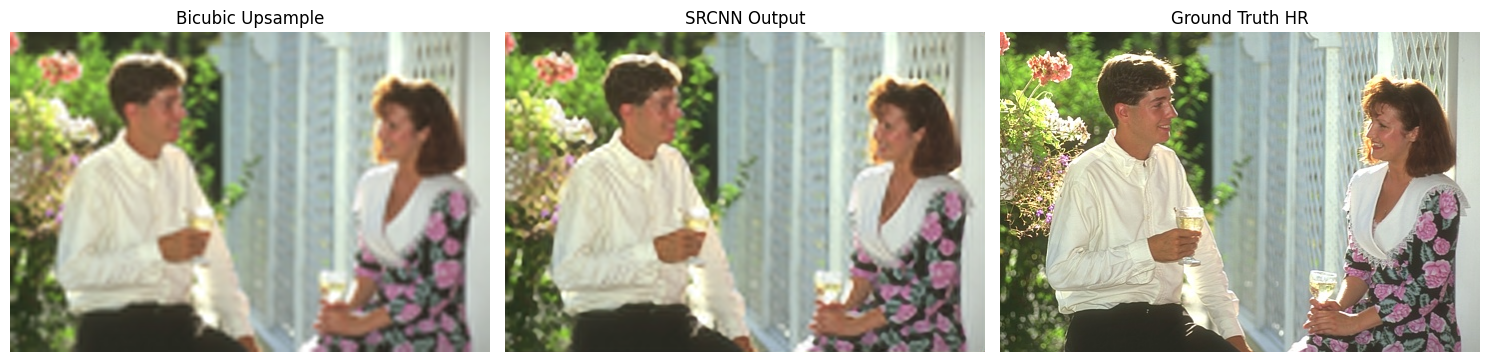

In [5]:
i = random.randint(0, len(test_lr) - 1)
#Random test image
visualize(model, os.path.join(test_lr, os.listdir(test_lr)[0]), os.path.join(test_hr, os.listdir(test_hr)[0]), device)


In [6]:
evaluate(model, test_lr, test_hr, device)


Average PSNR: 25.64
Average SSIM: 0.6687


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12422589..1.0413836].


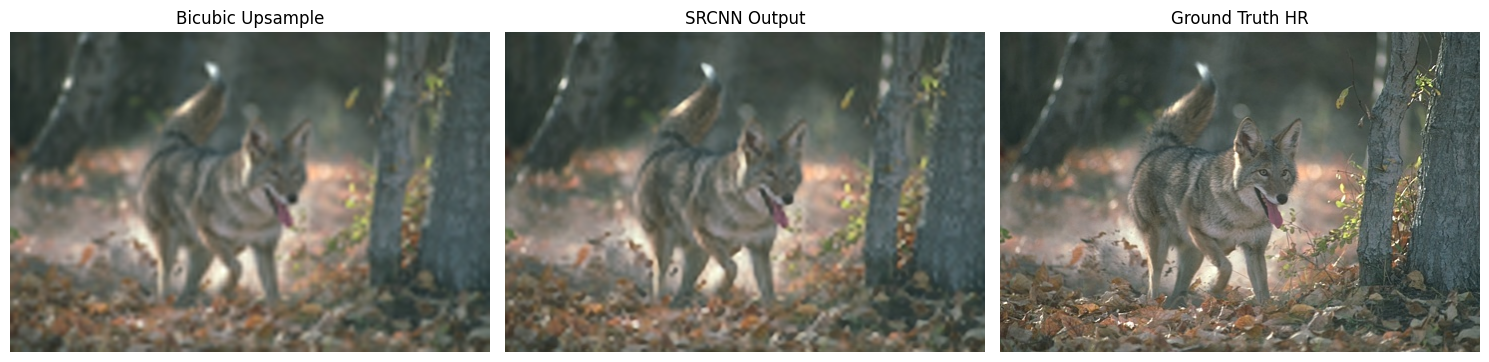

In [23]:
i = 16
visualize(model, os.path.join(test_lr, os.listdir(test_lr)[i]), os.path.join(test_hr, os.listdir(test_hr)[i]), device)